**This is the notebook for the practical part of lab 1.** 

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import gzip
import json
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec
import re
import copy

#import data_loading_code as dlc

In [3]:
print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

True
Using device: cuda


## Load data

In [4]:
def preprocess_pandas(data): #, columns
    # df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    # for index, row in data.iterrows():
    #     word_tokens = word_tokenize(row['Sentence'])
    #     filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
    #     df_.loc[len(df_)] = {
    #         "index": row['index'],
    #         "Class": row['Class'],
    #         "Sentence": " ".join(filtered_sent)
    #     }
    #return df_
    return data


def split_data(data):
    # split the data into training, validation, and test splits
    # first get 50% for training
    X_train, X_rest, y_train, y_rest = train_test_split(
        data['Sentence'],
        data['Class'],
        test_size=0.5,
        random_state=0,
        shuffle=True
    )

    # split rest to get 50/20/30 split
    X_val, X_test, y_val, y_test = train_test_split(
        X_rest,
        y_rest,
        test_size=0.6,  # 60% of 50% = 30% test
        random_state=0,
        shuffle=True
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

small dataset

In [5]:
# load and pre-process data 
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)

data.columns = ['Sentence', 'Class']
data['index'] = data.index # add new column index
data = preprocess_pandas(data) # pre-process

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data)

large dataset

In [6]:
# load and pre-process data
data_large = pd.read_csv("amazon_cells_labelled_LARGE_25K.txt", delimiter='\t', header=None)

data_large.columns = ['Sentence', 'Class']
data_large['index'] = data_large.index
data_large = preprocess_pandas(data_large)

# Split data
X_train_l, X_val_l, X_test_l, y_train_l, y_val_l, y_test_l = split_data(data_large)

Loading amazon review dataset 

Download the amazon reviews dataset 'Electronics_5.json.gz' on https://nijianmo.github.io/amazon/index.html#subsets. It is 1.2GB big.

Use following cell once to load, preprocess, and safe the dataset.

In [6]:
# input_file = 'Electronics_5.json.gz'
# output_file = 'electronics_reviews_preprocessed.parquet'

# data_elec = []
# with gzip.open(input_file, 'rt', encoding='utf-8') as f:
#     for idx, line in enumerate(f):
#         try:
#             review = json.loads(line)
#             overall = review.get('overall')
#             text = review.get('reviewText')
#             if overall is not None and text:  # ensure both exist
#                 data_elec.append({
#                     'index': idx,
#                     'Class': overall,
#                     'Sentence': text.strip()
#                 })
#         except json.JSONDecodeError:
#             continue  # skip malformed lines

# # Convert to DataFrame
# data_elec = pd.DataFrame(data_elec)

# # Preprocess data
# data_elec = preprocess_pandas(data_elec)

# # Converte DataFrame to PyArrow Table
# table = pa.Table.from_pandas(data_elec)

# # Save data in Parquet file to quickly access it again
# pq.write_table(table, output_file)


In [7]:
# # Load preprocessed dataset
# table = pq.read_table('electronics_reviews_preprocessed.parquet')
# data_elec = table.to_pandas()

# # Split data
# X_train_elec, X_val_elec, X_test_elec, y_train_elec, y_val_elec, y_test_elec = split_data(data_elec)

## Vectorise using tfidf

In [7]:
def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, tfidf_vectorizer, batch_size=32):
    """
    Convert text data to TF-IDF vectors, then to PyTorch tensors, and return DataLoaders for train, validation, and test sets.
    
    Parameters:
    - X_train: List or array of training sentences.
    - X_val: List or array of validation sentences.
    - X_test: List or array of test sentences.
    - y_train: List or array of training labels.
    - y_val: List or array of validation labels.
    - y_test: List or array of test labels.
    - tfidf_vectorizer: A fitted TfidfVectorizer.
    - batch_size: Batch size for DataLoader (default is 32).
    
    Returns:
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    - test_loader: DataLoader for the test set.
    """
    
    # Transform texts to sparse matrix and then to dense matrix for Pytorch
    X_train_vec = tfidf_vectorizer.fit_transform(X_train).todense()
    X_val_vec = tfidf_vectorizer.transform(X_val).todense()
    X_test_vec = tfidf_vectorizer.transform(X_test).todense()

    # Convert to tensors
    train_x_tensor = torch.from_numpy(np.array(X_train_vec)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor)

    val_x_tensor = torch.from_numpy(np.array(X_val_vec)).type(torch.FloatTensor)
    val_y_tensor = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor)

    test_x_tensor = torch.from_numpy(np.array(X_test_vec)).type(torch.FloatTensor)
    test_y_tensor = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor)

    # Build datasets
    train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
    val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
    test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [8]:
# vectorize data using TFIDF and transform for PyTorch for scalability
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')

**Create DataLoaders**

small dataset

In [9]:
train_loader, val_loader, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, tfidf_vectorizer, batch_size=16)

large dataset

In [10]:
train_loader_l, val_loader_l, test_loader_l = create_data_loaders(X_train_l, X_val_l, X_test_l, y_train_l, y_val_l, y_test_l, tfidf_vectorizer)

: 

amazon electronics review dataset

In [12]:
# train_loader_elec, val_loader_elec, test_loader_elec = create_data_loaders(X_train_elec, X_val_elec, X_test_elec, y_train_elec, y_val_elec, y_test_elec, tfidf_vectorizer)

## Sentence embeddings using Word2Vec for vectorization

In [13]:
# # load pretrained word2vec model with dimension 100
# word2vec_model = api.load("glove-wiki-gigaword-100")
# embedding_dim = 100 

In [14]:
sentences = list(X_train) + list(X_val) + list(X_test)
# Tokenize sentences
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

sentences_l = list(X_train_l) + list(X_val_l) + list(X_test_l)
# Tokenize sentences
tokenized_sentences_l = [word_tokenize(sentence.lower()) for sentence in sentences_l]

In [15]:
# Train Word2Vec 
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,       # dimension of vectors
    window=5,              
    min_count=1,           # min. appearance of a word in dataset
    workers=4,             
    sg=0                   # 1 = skip-gram, 0 = CBOW
)

word2vec_model_l = Word2Vec(
    sentences=tokenized_sentences_l,
    vector_size=100,       # dimension of vectors
    window=5,              
    min_count=1,           # min. appearance of a word in dataset
    workers=4,             
    sg=0                   # 1 = skip-gram, 0 = CBOW
)

In [16]:
# Function to convert sentences into embeddings
def sentence_to_vec(sentence, model, embedding_dim=100):
    words = sentence.split()
    vec = torch.zeros(embedding_dim)
    word_count = 0
    for word in words:
        if word in model.wv:
            vec += torch.tensor(model.wv[word])
            word_count += 1
    if word_count > 0:
        vec /= word_count
    return vec

# Convert all sentences to embeddings for the datasets
def create_dataset(X, y, word2vec_model, embedding_dim=100):
    x_tensor = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X])
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32)  # Binary labels as float32
    return x_tensor, y_tensor

small dataset

In [17]:
# Create Tensor datasets
train_x_tensor_w2v, train_y_tensor_w2v = create_dataset(X_train, y_train, word2vec_model)
val_x_tensor_w2v, val_y_tensor_w2v = create_dataset(X_val, y_val, word2vec_model)
test_x_tensor_w2v, test_y_tensor_w2v = create_dataset(X_test, y_test, word2vec_model)

# Build datasets and DataLoaders
train_loader_w2v = DataLoader(TensorDataset(train_x_tensor_w2v, train_y_tensor_w2v), batch_size=32, shuffle=True)
val_loader_w2v = DataLoader(TensorDataset(val_x_tensor_w2v, val_y_tensor_w2v), batch_size=32, shuffle=False)
test_loader_w2v = DataLoader(TensorDataset(test_x_tensor_w2v, test_y_tensor_w2v), batch_size=32, shuffle=False)

large dataset

In [18]:
# Create Tensor datasets
train_x_tensor_w2v_l, train_y_tensor_w2v_l = create_dataset(X_train_l, y_train_l, word2vec_model_l)
val_x_tensor_w2v_l, val_y_tensor_w2v_l = create_dataset(X_val_l, y_val_l, word2vec_model_l)
test_x_tensor_w2v_l, test_y_tensor_w2v_l = create_dataset(X_test_l, y_test_l, word2vec_model_l)

# Build datasets and DataLoaders
train_loader_w2v_l = DataLoader(TensorDataset(train_x_tensor_w2v_l, train_y_tensor_w2v_l), batch_size=32, shuffle=True)
val_loader_w2v_l = DataLoader(TensorDataset(val_x_tensor_w2v_l, val_y_tensor_w2v_l), batch_size=32, shuffle=False)
test_loader_w2v_l = DataLoader(TensorDataset(test_x_tensor_w2v_l, test_y_tensor_w2v_l), batch_size=32, shuffle=False)

---

# ANN Classifier

In [19]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [20]:
class SimpleANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(SimpleANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc2 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [21]:
class ANNClassifierLarge(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifierLarge, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.drop2 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(16, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = self.drop2(self.relu3(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))  # Sigmoid for binary classification
        return x

In [22]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_loss_array = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)  # [batch, 1] for BCELoss
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss / len(train_loader)
        train_loss_array.append(training_loss)

        val_loss, val_acc, _, _ = test_model(loader=val_loader, model=model, criterion=criterion)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model.name)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print(f"Best validation accuracy: {best_accuracy}%")
    return model


def test_model(loader, model=None, criterion=None, input_size=None):
    if model is None:
        model = ANNClassifier(input_size)
        model.load_state_dict(torch.load('amazonclass.pth'))

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.squeeze().tolist())
            all_preds.extend(predicted.squeeze().tolist())

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total

    return loss, accuracy, np.array(all_labels), np.array(all_preds)

In [23]:
def plot_confusion_matrix(all_labels=None, all_predictions=None, class_labels=None):
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
        return

    if class_labels is None:
        class_labels = ["Negative (0)", "Positive (1)"]  # Default

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)
    # print("Confusion Matrix:\n", cm)

    # Plot it with descriptive labels
    fig, ax = plt.subplots(figsize=(6, 6))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

---

# Training and Evaluation of ANNs

## Train simple ANN Classifier on small dataset

In [24]:
model_name ='amazonclasssimple'
input_size = next(iter(train_loader))[0].shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=250)

Epoch 1/250, Train Loss: 0.7718, Val Loss: 0.6944, Train Acc: 49.20%, Val Acc: 48.00%
Epoch 2/250, Train Loss: 0.7240, Val Loss: 0.6927, Train Acc: 52.00%, Val Acc: 50.00%
Epoch 3/250, Train Loss: 0.7026, Val Loss: 0.6885, Train Acc: 53.60%, Val Acc: 52.00%
Epoch 4/250, Train Loss: 0.6728, Val Loss: 0.6836, Train Acc: 56.80%, Val Acc: 56.00%
Epoch 5/250, Train Loss: 0.6460, Val Loss: 0.6741, Train Acc: 59.20%, Val Acc: 59.50%
Epoch 6/250, Train Loss: 0.6390, Val Loss: 0.6665, Train Acc: 59.00%, Val Acc: 61.00%
Epoch 7/250, Train Loss: 0.6018, Val Loss: 0.6595, Train Acc: 62.60%, Val Acc: 61.50%
Epoch 8/250, Train Loss: 0.5989, Val Loss: 0.6533, Train Acc: 62.80%, Val Acc: 62.00%
Epoch 9/250, Train Loss: 0.5828, Val Loss: 0.6454, Train Acc: 63.80%, Val Acc: 62.00%
Epoch 10/250, Train Loss: 0.5463, Val Loss: 0.6436, Train Acc: 68.20%, Val Acc: 62.50%
Epoch 11/250, Train Loss: 0.5647, Val Loss: 0.6358, Train Acc: 67.40%, Val Acc: 63.00%
Epoch 12/250, Train Loss: 0.5485, Val Loss: 0.6281, 

Accuracy on testing dataset: 82.66666666666667%
F1-Score: 0.84


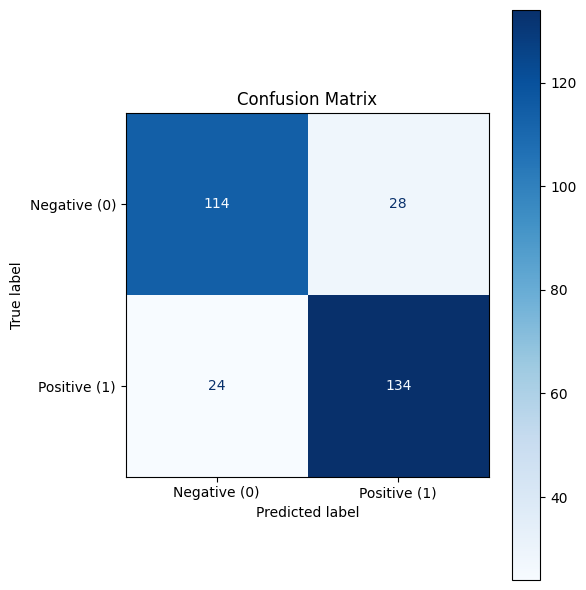

In [25]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train simple ANN Classifier on large dataset

In [26]:
model_name ='amazonclasssimplelarge'
input_size = next(iter(train_loader_l))[0].shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_l, val_loader_l, num_epochs=25)

Epoch 1/25, Train Loss: 0.6672, Val Loss: 0.5740, Train Acc: 53.98%, Val Acc: 72.18%
Epoch 2/25, Train Loss: 0.5743, Val Loss: 0.5148, Train Acc: 64.10%, Val Acc: 80.36%
Epoch 3/25, Train Loss: 0.5185, Val Loss: 0.4763, Train Acc: 69.27%, Val Acc: 83.02%
Epoch 4/25, Train Loss: 0.4782, Val Loss: 0.4404, Train Acc: 71.53%, Val Acc: 85.56%
Epoch 5/25, Train Loss: 0.4448, Val Loss: 0.3913, Train Acc: 73.20%, Val Acc: 87.24%
Epoch 6/25, Train Loss: 0.4130, Val Loss: 0.3732, Train Acc: 74.32%, Val Acc: 87.76%
Epoch 7/25, Train Loss: 0.3809, Val Loss: 0.3557, Train Acc: 75.80%, Val Acc: 87.94%
Epoch 8/25, Train Loss: 0.3660, Val Loss: 0.3482, Train Acc: 76.24%, Val Acc: 87.82%
Epoch 9/25, Train Loss: 0.3460, Val Loss: 0.3253, Train Acc: 76.36%, Val Acc: 87.98%
Epoch 10/25, Train Loss: 0.3324, Val Loss: 0.3126, Train Acc: 76.98%, Val Acc: 88.06%
Epoch 11/25, Train Loss: 0.3166, Val Loss: 0.3069, Train Acc: 77.65%, Val Acc: 88.00%
Epoch 12/25, Train Loss: 0.3037, Val Loss: 0.3033, Train Acc: 8

Accuracy on testing dataset: 88.16%
F1-Score: 0.90


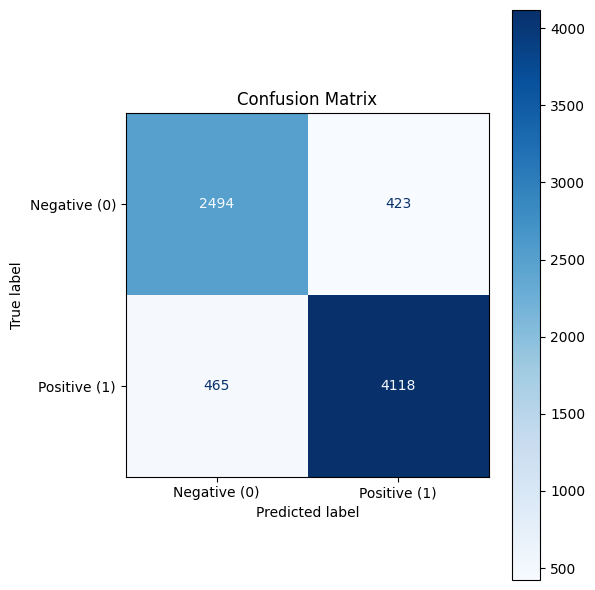

In [27]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train ANN Classifier on large dataset

In [28]:
model_name_l = 'amazonclasslarge'
input_size = next(iter(train_loader_l))[0].shape[1]
model = ANNClassifier(input_size, model_name_l)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_l, val_loader_l, num_epochs=25)

Epoch 1/25, Train Loss: 0.5652, Val Loss: 0.4245, Train Acc: 69.23%, Val Acc: 84.26%
Epoch 2/25, Train Loss: 0.4172, Val Loss: 0.3457, Train Acc: 79.46%, Val Acc: 87.24%
Epoch 3/25, Train Loss: 0.3105, Val Loss: 0.3181, Train Acc: 82.84%, Val Acc: 86.80%
Epoch 4/25, Train Loss: 0.2430, Val Loss: 0.3227, Train Acc: 84.58%, Val Acc: 87.20%
Epoch 5/25, Train Loss: 0.2089, Val Loss: 0.3540, Train Acc: 85.55%, Val Acc: 86.40%
Epoch 6/25, Train Loss: 0.1950, Val Loss: 0.3651, Train Acc: 87.13%, Val Acc: 85.82%
Epoch 7/25, Train Loss: 0.1922, Val Loss: 0.3870, Train Acc: 91.17%, Val Acc: 85.58%
Epoch 8/25, Train Loss: 0.1904, Val Loss: 0.4074, Train Acc: 94.93%, Val Acc: 86.40%
Epoch 9/25, Train Loss: 0.2026, Val Loss: 0.4308, Train Acc: 89.83%, Val Acc: 86.48%
Epoch 10/25, Train Loss: 0.1929, Val Loss: 0.4197, Train Acc: 88.99%, Val Acc: 86.00%
Epoch 11/25, Train Loss: 0.1832, Val Loss: 0.4542, Train Acc: 89.53%, Val Acc: 86.68%
Epoch 12/25, Train Loss: 0.1860, Val Loss: 0.4486, Train Acc: 8

Accuracy on testing dataset: 87.29333333333334%
F1-Score: 0.90


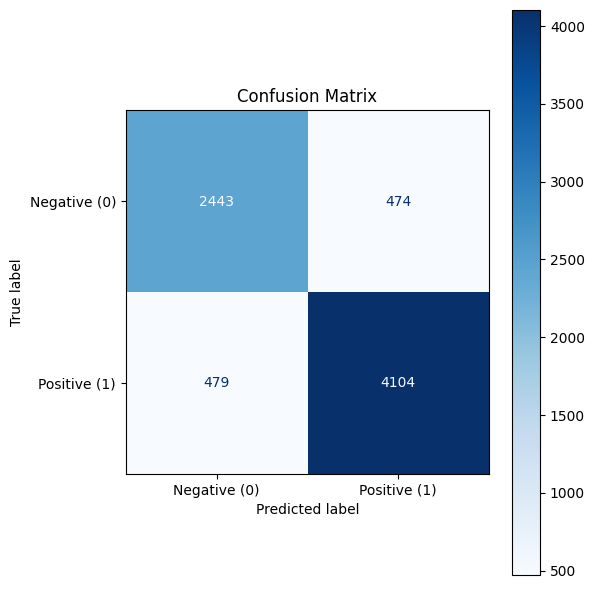

In [29]:
# Load best model
model = ANNClassifier(input_size, model_name_l)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

---

## Train ANN with word embeddings
small dataset and small model

In [30]:
model_name ='amazonclasssimplew2v'
input_size = train_x_tensor_w2v.shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v, val_loader_w2v, num_epochs=500)

Epoch 1/500, Train Loss: 0.7711, Val Loss: 0.7211, Train Acc: 48.80%, Val Acc: 47.00%
Epoch 2/500, Train Loss: 0.7501, Val Loss: 0.7194, Train Acc: 49.60%, Val Acc: 47.00%
Epoch 3/500, Train Loss: 0.7317, Val Loss: 0.7197, Train Acc: 49.00%, Val Acc: 47.00%
Epoch 4/500, Train Loss: 0.7362, Val Loss: 0.7188, Train Acc: 49.40%, Val Acc: 47.00%
Epoch 5/500, Train Loss: 0.7392, Val Loss: 0.7256, Train Acc: 49.40%, Val Acc: 47.00%
Epoch 6/500, Train Loss: 0.7262, Val Loss: 0.7634, Train Acc: 50.00%, Val Acc: 47.00%
Epoch 7/500, Train Loss: 0.7153, Val Loss: 0.7264, Train Acc: 49.20%, Val Acc: 47.00%
Epoch 8/500, Train Loss: 0.7104, Val Loss: 0.7950, Train Acc: 50.80%, Val Acc: 47.00%
Epoch 9/500, Train Loss: 0.7181, Val Loss: 0.7269, Train Acc: 51.40%, Val Acc: 47.00%
Epoch 10/500, Train Loss: 0.7155, Val Loss: 0.7151, Train Acc: 52.60%, Val Acc: 47.00%
Epoch 11/500, Train Loss: 0.7115, Val Loss: 0.7172, Train Acc: 49.60%, Val Acc: 47.00%
Epoch 12/500, Train Loss: 0.7144, Val Loss: 0.7168, 

Accuracy on testing dataset: 65.66666666666667%
F1-Score: 0.61


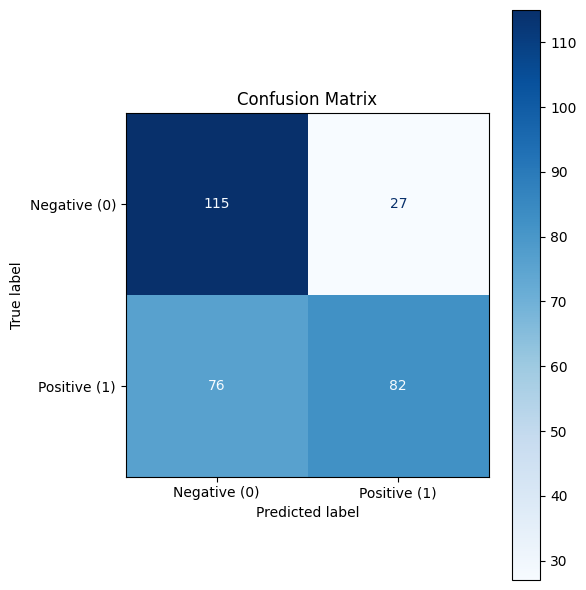

In [31]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

larger dataset and larger model

In [32]:
model_name ='amazonclasssimplew2vlarge'
input_size = train_x_tensor_w2v_l.shape[1]
model = ANNClassifierLarge(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v_l, val_loader_w2v_l, num_epochs=50)

Epoch 1/50, Train Loss: 0.5124, Val Loss: 0.4537, Train Acc: 74.33%, Val Acc: 77.78%
Epoch 2/50, Train Loss: 0.4617, Val Loss: 0.4588, Train Acc: 77.94%, Val Acc: 76.64%
Epoch 3/50, Train Loss: 0.4554, Val Loss: 0.4391, Train Acc: 77.91%, Val Acc: 78.50%
Epoch 4/50, Train Loss: 0.4395, Val Loss: 0.4431, Train Acc: 78.87%, Val Acc: 78.02%
Epoch 5/50, Train Loss: 0.4360, Val Loss: 0.4367, Train Acc: 78.94%, Val Acc: 78.46%
Epoch 6/50, Train Loss: 0.4322, Val Loss: 0.4349, Train Acc: 79.40%, Val Acc: 78.86%
Epoch 7/50, Train Loss: 0.4272, Val Loss: 0.4739, Train Acc: 79.69%, Val Acc: 76.32%
Epoch 8/50, Train Loss: 0.4195, Val Loss: 0.4462, Train Acc: 79.88%, Val Acc: 78.04%
Epoch 9/50, Train Loss: 0.4231, Val Loss: 0.4455, Train Acc: 80.07%, Val Acc: 78.16%
Epoch 10/50, Train Loss: 0.4082, Val Loss: 0.4445, Train Acc: 80.84%, Val Acc: 78.70%
Epoch 11/50, Train Loss: 0.4043, Val Loss: 0.4380, Train Acc: 80.98%, Val Acc: 79.18%
Epoch 12/50, Train Loss: 0.4107, Val Loss: 0.4313, Train Acc: 8

Accuracy on testing dataset: 78.8%
F1-Score: 0.82


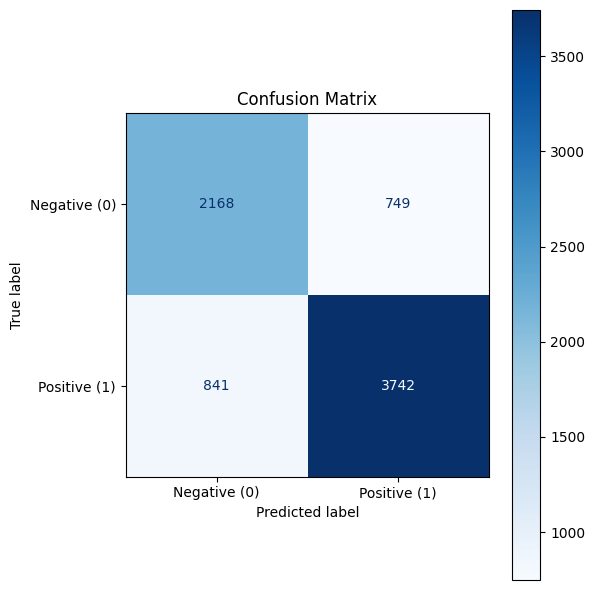

In [33]:
# Load best model
model = ANNClassifierLarge(input_size, model_name)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

---

# Transformer

### RoBERTa

In this part we use the RoBERTa transformer to fine tune the model for classification

In [7]:

from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score

/home/user/labs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def create_dataset(X_train, y_train, X_val, y_val, X_test, y_test):
    train_dataset = Dataset.from_dict({"sentence": X_train, "labels": y_train})
    val_dataset = Dataset.from_dict({"sentence": X_val, "labels": y_val})
    test_dataset = Dataset.from_dict({"sentence": X_test, "labels": y_test})
    return train_dataset.map(tokenize, batched=True), val_dataset.map(tokenize, batched=True), test_dataset.map(tokenize, batched=True)

def tokenize(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "precision": precision_score(labels, preds),
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "recall": recall_score(labels, preds)
    }

# Create small and large dataset
train_dataset, val_dataset, test_dataset = create_dataset(X_train, y_train, X_val, y_val, X_test, y_test)
train_dataset_l, val_dataset_l, test_dataset_l = create_dataset(X_train_l, y_train_l, X_val_l, y_val_l, X_test_l, y_test_l)

Map: 100%|██████████| 7500/7500 [00:01<00:00, 5891.41 examples/s]


In [28]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        logging_dir="./logs",
        num_train_epochs=3,
        per_device_train_batch_size=8
    ),
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,No log,0.298316,0.954023,0.925000,0.917127,0.882979
2,No log,0.571897,0.849057,0.900000,0.900000,0.957447
3,No log,0.254291,0.946809,0.950000,0.946809,0.946809


TrainOutput(global_step=189, training_loss=0.2952616252596416, metrics={'train_runtime': 112.7971, 'train_samples_per_second': 13.298, 'train_steps_per_second': 1.676, 'total_flos': 30062493630000.0, 'train_loss': 0.2952616252596416, 'epoch': 3.0})

In [29]:

metrics = trainer.evaluate(
    eval_dataset=test_dataset,
)

print(metrics)

{'eval_loss': 0.20251715183258057, 'eval_precision': 0.9625, 'eval_accuracy': 0.9666666666666667, 'eval_f1': 0.9685534591194969, 'eval_recall': 0.9746835443037974, 'eval_runtime': 3.3241, 'eval_samples_per_second': 90.25, 'eval_steps_per_second': 11.432, 'epoch': 3.0}


In [30]:
# It is really fancy to try it a bit out
text = "does what it promised"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities.numpy()}")

Predicted class: 1
Probabilities: [[0.0043547 0.9956453]]


In [9]:
model_l = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
trainer_l = Trainer(
    model=model_l,
    args=TrainingArguments(
        output_dir="./results_large",
        eval_strategy="epoch",
        logging_dir="./logs_large",
        num_train_epochs=3,
        per_device_train_batch_size=8
    ),
    train_dataset = train_dataset_l,
    eval_dataset = val_dataset_l,
    compute_metrics=compute_metrics
)

trainer_l.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.329300,0.276609,0.935792,0.917800,0.932568,0.929366
2,0.219700,0.253355,0.947941,0.932200,0.944362,0.940811
3,0.148100,0.298459,0.942221,0.936400,0.948343,0.954545


TrainOutput(global_step=4689, training_loss=0.24563814017990807, metrics={'train_runtime': 1082.5085, 'train_samples_per_second': 34.642, 'train_steps_per_second': 4.332, 'total_flos': 9866664576000000.0, 'train_loss': 0.24563814017990807, 'epoch': 3.0})

In [10]:
metrics = trainer_l.evaluate(
    eval_dataset=test_dataset_l,
)

print(metrics)

{'eval_loss': 0.2807043194770813, 'eval_precision': 0.9447918913090361, 'eval_accuracy': 0.9389333333333333, 'eval_f1': 0.9503253796095444, 'eval_recall': 0.9559240672048877, 'eval_runtime': 54.6927, 'eval_samples_per_second': 137.13, 'eval_steps_per_second': 17.15, 'epoch': 3.0}
